# IMPORT LIBRARIES

In [1]:
import requests
import pandas as pd
from IPython.display import display
import folium
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.cluster import DBSCAN
import random
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from collections import defaultdict
from branca.element import Template, MacroElement

# DATA SCRAPING AND GATHERING

The cell below is part of the code used to scrape or query geospatial data from a crowdsourced map database called "OpenStreetMap". The selected locations for this geospatial analysis are Central Jakarta, West Jakarta, and South Jakarta. These three cities were chosen based on Indonesia’s population density data per km² in 2023, which can be viewed at https://id.wikipedia.org/wiki/Daftar_kota_di_Indonesia_menurut_kepadatan_penduduk. These three administrative cities have the highest population density per km² compared to other cities in different provinces.

In [2]:
def get_indomaret_locations(city_name):
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    area["name"="{city_name}"]->.searchArea;
    (
      node["name"~"Indomaret"](area.searchArea);
      way["name"~"Indomaret"](area.searchArea);
      relation["name"~"Indomaret"](area.searchArea);
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    locations = []
    for element in data['elements']:
        if 'lat' in element:
            lat = element['lat']
            lon = element['lon']
        elif 'center' in element:
            lat = element['center']['lat']
            lon = element['center']['lon']
        else:
            continue
        name = element['tags'].get('name', 'Indomaret')
        locations.append({
            'name': name,
            'lat': lat,
            'lon': lon,
            'type': element['type'],
            'tags': element.get('tags', {})
        })
    
    return pd.DataFrame(locations)

jaksel_df = get_indomaret_locations("Jakarta Selatan")
jakpus_df = get_indomaret_locations("Jakarta Pusat")
jakbar_df = get_indomaret_locations("Jakarta Barat")

jaksel_df["city"] = "Jakarta Selatan"
jakpus_df["city"] = "Jakarta Pusat"
jakbar_df["city"] = "Jakarta Barat"


In [3]:
pd.set_option('display.max_colwidth', None)

# PRE-PROCESSING

As shown below, this is the display of the dataframe information for each city selected for the analysis. The dataframe contains the following columns: "name" for the store name, "lat" for latitude, "lon" for longitude, "type" indicating the type of data queried from the database, "tags" which provides additional information about the store, and "city" indicating the city where the store is located. It can also be seen that each city has more than 100 Indomaret stores.

In [4]:
jaksel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    129 non-null    object 
 1   lat     129 non-null    float64
 2   lon     129 non-null    float64
 3   type    129 non-null    object 
 4   tags    129 non-null    object 
 5   city    129 non-null    object 
dtypes: float64(2), object(4)
memory usage: 6.2+ KB


In [5]:
jakpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    103 non-null    object 
 1   lat     103 non-null    float64
 2   lon     103 non-null    float64
 3   type    103 non-null    object 
 4   tags    103 non-null    object 
 5   city    103 non-null    object 
dtypes: float64(2), object(4)
memory usage: 5.0+ KB


In [6]:
jakbar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    100 non-null    object 
 1   lat     100 non-null    float64
 2   lon     100 non-null    float64
 3   type    100 non-null    object 
 4   tags    100 non-null    object 
 5   city    100 non-null    object 
dtypes: float64(2), object(4)
memory usage: 4.8+ KB


In [7]:
jakbar_df.head()

,name,lat,lon,type,tags,city
0,Indomaret,-6.199029,106.782156,node,"{'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Barat
1,Indomaret,-6.201324,106.782744,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'operator': 'PT. Indomarco Prismatama', 'payment:coins': 'yes', 'payment:ep_brizzi': 'yes', 'payment:ep_mandiri_emoney': 'yes', 'payment:gpn_debit': 'yes', 'payment:isaku': 'yes', 'payment:linkaja': 'yes', 'payment:maestro': 'yes', 'payment:mastercard': 'yes', 'payment:notes': 'yes', 'payment:otto_pay': 'yes', 'payment:visa': 'yes', 'payment:visa_debit': 'yes', 'payment:visa_electron': 'yes', 'shop': 'convenience', 'website': 'https://indomaret.co.id/'}",Jakarta Barat
2,Indomaret,-6.200859,106.785117,node,"{'addr:housenumber': '1', 'addr:street': 'Jalan KH. Syahdan', 'branch': 'Syahdan', 'brand': 'Indomaret', 'name': 'Indomaret', 'operator': 'CV. Puri Anita', 'phone': '+62 811-9690-589', 'ref:vatin': 'ID03.093.515.9-031.000', 'shop': 'convenience'}",Jakarta Barat
3,Indomaret,-6.178127,106.779195,node,"{'branch': 'Duri Kepa', 'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Barat
4,Indomaret,-6.193376,106.782361,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Barat


In [8]:
jakpus_df.head()

,name,lat,lon,type,tags,city
0,Indomaret,-6.184103,106.829433,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'name:ja': 'インドマレット', 'shop': 'convenience'}",Jakarta Pusat
1,Indomaret,-6.167478,106.814124,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'opening_hours': 'Mo-Su 07:00-22:00', 'operator': 'Indomaret', 'shop': 'convenience'}",Jakarta Pusat
2,Indomaret,-6.184609,106.829283,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'name:ja': 'インドマレット', 'opening_hours': '24/7', 'shop': 'convenience'}",Jakarta Pusat
3,Indomaret,-6.193723,106.820632,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'name:en': 'Indomaret', 'name:ja': 'インドマレット', 'shop': 'convenience'}",Jakarta Pusat
4,Indomaret,-6.197988,106.849813,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'name': 'Indomaret', 'name:ja': 'インドマレット', 'opening_hours': 'Mo-Su 06:00-22:00', 'shop': 'convenience'}",Jakarta Pusat


In [9]:
jaksel_df.head()

,name,lat,lon,type,tags,city
0,Indomaret Bona Indah,-6.297469,106.782663,node,"{'name': 'Indomaret Bona Indah', 'shop': 'convenience'}",Jakarta Selatan
1,Indomaret,-6.224148,106.852607,node,"{'addr:housename': 'Indomaret', 'addr:street': 'KH Abdul Syafii', 'branch': 'KH Abdul Syafii', 'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Selatan
2,Indomaret,-6.277702,106.772888,node,"{'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Selatan
3,Indomaret,-6.215368,106.828091,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Selatan
4,Indomaret,-6.255527,106.812237,node,"{'brand': 'Indomaret', 'brand:wikidata': 'Q4262825', 'brand:wikipedia': 'en:Indomaret', 'name': 'Indomaret', 'shop': 'convenience'}",Jakarta Selatan


Cell dibawah ini merupakan code untuk menggabungkan 3 dataframes yang ditunjukkan di atas menjadi 1

In [10]:
df = pd.concat([jaksel_df, jakpus_df, jakbar_df], ignore_index=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    332 non-null    object 
 1   lat     332 non-null    float64
 2   lon     332 non-null    float64
 3   type    332 non-null    object 
 4   tags    332 non-null    object 
 5   city    332 non-null    object 
dtypes: float64(2), object(4)
memory usage: 15.7+ KB


The cell below contains the code used to remove duplicate data.

In [12]:
df[df['name'].str.contains('fatmawati', case=False, na=False)]

,name,lat,lon,type,tags,city
25,Fatmawati Indomaret,-6.292471,106.792463,node,"{'name': 'Fatmawati Indomaret', 'network': 'MRT Jakarta', 'public_transport': 'stop_position', 'railway': 'stop', 'subway': 'yes'}",Jakarta Selatan
26,Fatmawati Indomaret,-6.292428,106.792466,node,"{'name': 'Fatmawati Indomaret', 'network': 'MRT Jakarta', 'public_transport': 'stop_position', 'railway': 'stop', 'subway': 'yes'}",Jakarta Selatan
43,Fatmawati Indomaret,-6.292451,106.792464,node,"{'alt_name': 'Stasiun Fatmawati', 'internet_access': 'yes', 'name': 'Fatmawati Indomaret', 'network': 'MRT Jakarta', 'network:short': 'MRTJ', 'network:wikidata': 'Q3333785', 'operator': 'MRT Jakarta', 'operator:wikidata': 'Q3333785', 'public_transport': 'station', 'railway': 'station', 'station': 'subway', 'subway': 'yes', 'website': 'https://jakartamrt.co.id/', 'wikidata': 'Q61365063', 'wikipedia': 'id:Stasiun MRT Fatmawati'}",Jakarta Selatan
128,Stasiun MRT Fatmawati Indomaret,-6.292467,106.792454,way,"{'alt_name': 'Stasiun MRT Fatmawati', 'building': 'train_station', 'layer': '1', 'name': 'Stasiun MRT Fatmawati Indomaret'}",Jakarta Selatan


In [13]:
df = df[~df['name'].str.lower().eq('fatmawati indomaret')]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 0 to 331
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    329 non-null    object 
 1   lat     329 non-null    float64
 2   lon     329 non-null    float64
 3   type    329 non-null    object 
 4   tags    329 non-null    object 
 5   city    329 non-null    object 
dtypes: float64(2), object(4)
memory usage: 18.0+ KB


# ANALYSIS

Below is a visualization of the distribution of store counts in each selected administrative city: South Jakarta, West Jakarta, and Central Jakarta. It can be seen that South Jakarta has the highest number of Indomaret stores compared to the other cities, while West Jakarta has the fewest.

C:\Users\Republic Of Gamers\AppData\Local\Temp\ipykernel_27008\1838471110.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "city", data = df, palette="Spectral")


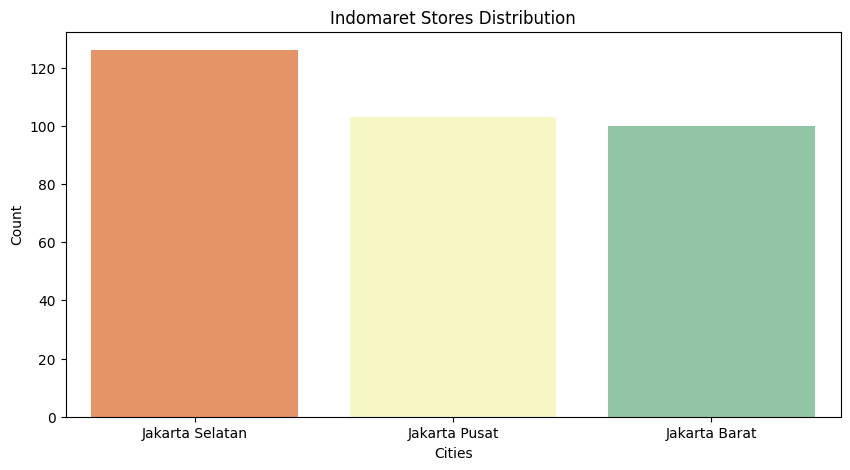

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(x = "city", data = df, palette="Spectral")
plt.title("Indomaret Stores Distribution")
plt.xlabel("Cities")
plt.ylabel("Count")
plt.show()

Below is an interactive map showing the distribution of Indomaret store locations across the three selected administrative cities. The green dots represent stores in Central Jakarta, the blue dots represent stores in South Jakarta, and the black dots represent stores in West Jakarta.

Folium is implemented to present the interactive map, making the analysis easier and more practical. Folium is a Python library that utilizes Leaflet.js, an open-source JavaScript library for interactive maps.

The coordinate points used represent locations specifically within Indonesia, particularly in the Jakarta area.

It can also be seen that the distribution of Indomaret stores in South Jakarta is not as dense as in Central Jakarta and West Jakarta, even though South Jakarta has the highest number of stores.

In [16]:
map_indomaret = folium.Map(location=[-6.2, 106.8], zoom_start=6)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        popup=row['name'],
        color="blue" if row['city'] == "Jakarta Selatan" else
              "green" if row['city'] == "Jakarta Pusat" else "Jakarta Barat",
        fill=True,
        fill_opacity=0.7
    ).add_to(map_indomaret)

display(map_indomaret)


The table below shows the average distance between the nearest Indomaret stores within each administrative city, measured in kilometers.

The Nearest Neighbors algorithm is widely used in spatial analysis because it is faster and more efficient than manually looping through every pair of coordinates, especially for distance calculations. However, this method requires the use of radians as the unit for distance calculations. The metric used is "haversine", which calculates the distance between one coordinate point and another.

The average nearest distance between Indomaret stores in Central Jakarta is **0.28 km**. In West Jakarta, it is **0.39 km**, and in South Jakarta, it is approximately **0.52 km**.

In [17]:
average_closest_distance = {}

for city, group in df.groupby('city'):
    coordsDegree = group[['lat', 'lon']].to_numpy()
    
    if len(coordsDegree) > 1:
        radians = np.radians(coordsDegree)
        nn = NearestNeighbors(n_neighbors=2, metric='haversine')
        nn.fit(radians)
        distances, _ = nn.kneighbors(radians)
        
        distances_km = distances[:, 1] * 6371
        average_closest_distance[city] = distances_km.mean()

In [18]:
avg_dist_df = pd.DataFrame.from_dict(average_closest_distance, orient='index', columns=['avg_nearest_km'])
avg_dist_df = avg_dist_df.sort_values(by='avg_nearest_km')

avg_dist_df

,avg_nearest_km
Jakarta Pusat,0.282695
Jakarta Barat,0.393143
Jakarta Selatan,0.523007


Below is an interactive map showing clusters of at least 3 Indomaret stores that are located within a maximum distance of 0.5 km from each other. Clustering is performed by assigning a numerical label to each cluster, and stores within the same cluster are given the same color to indicate that they belong to the same group.

DBSCAN is used to make clustering more practical, as it can identify groups of data with irregular shapes and effectively detect outliers (stores without a cluster). This makes it highly suitable for geographic data, especially when combined with the haversine metric. Folium is also used to create the interactive map shown below.

By observing the interactive map below, strategies can be devised for future store openings. New branches can be established in areas that are not clustered or are less densely populated with other Indomaret stores.

In [20]:
coords = df[['lat', 'lon']].values
radians = np.radians(coords)

kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=3, metric='haversine').fit(radians)
df['cluster'] = db.labels_


map_indomaret = folium.Map(location=[-6.2, 106.8], zoom_start=11)

unique_labels = sorted(df['cluster'].unique())
used_colors = set()

def get_unique_darker_color():
    while True:
        r = random.randint(0, 150)
        g = random.randint(0, 150)
        b = random.randint(0, 150)
        color = f'#{r:02x}{g:02x}{b:02x}'
        if color not in used_colors:
            used_colors.add(color)
            return color

colors = {
    label: get_unique_darker_color() if label != -1 else 'black'
    for label in unique_labels
}

cluster_counts = defaultdict(int)
for _, row in df.iterrows():
    cluster_key = f"{row['city']} - Cluster {row['cluster']}" if row['cluster'] != -1 else f"{row['city']} - Outlier"
    cluster_counts[cluster_key] += 1

for _, row in df.iterrows():
    label = row['cluster']
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        color=colors[label],
        fill=True,
        fill_color=colors[label],
        fill_opacity=0.7,
        popup=f"Name: {row['name']}<br>Cluster: {row['cluster']}<br>City: {row['city']}"
    ).add_to(map_indomaret)

legend_items = ""
for label_name, count in sorted(cluster_counts.items()):
    if 'Outlier' in label_name:
        color = 'black'
    else:
        try:
            cluster_num = int(label_name.split('Cluster ')[-1])
            color = colors[cluster_num]
        except:
            color = '#888888'  # fallback
    legend_items += f"<li><span style='display:inline-block;width:12px;height:12px;background-color:{color};margin-right:6px;'></span>{label_name} ({count})</li>\n"

legend_html = f"""
{{% macro html(this, kwargs) %}}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    max-height: 300px;
    overflow-y: auto;
    background-color: white;
    border: 2px solid grey;
    border-radius: 6px;
    padding: 10px;
    z-index: 9999;
    font-size: 14px;
    box-shadow: 2px 2px 6px rgba(0, 0, 0, 0.3);
">
    <b>Cluster Legend</b><br>
    <ul style='list-style: none; padding-left: 0; margin: 0;'>
        {legend_items}
    </ul>
</div>
{{% endmacro %}}
"""

legend = MacroElement()
legend._template = Template(legend_html)
map_indomaret.get_root().add_child(legend)

map_indomaret


From the interactive map above, it can be seen that South Jakarta has the highest number of Indomaret stores that are not located close to each other (within approximately 0.5 km), compared to the other areas. Additionally, the number of Indomaret stores within each cluster in South Jakarta is not as many as in other cities. For example, the cluster with the most stores in South Jakarta (Cluster 9) contains around 6 stores. This is due to the fact that Cluster 9 is located in a densely populated residential area in South Jakarta.

For West Jakarta, it can be seen that the number of Indomaret stores that are not close together or not clustered (with a distance of approximately 0.5 km) is around 30 stores. The cluster with the highest number of Indomaret stores is Cluster 23, which contains 10 stores. In that area, the left side consists of residential neighborhoods, while the right side includes apartment complexes and a mall.

Central Jakarta has the fewest unclustered Indomaret stores compared to the other two areas, with only 19 stores not located within approximately 0.5 km of another. Cluster 13 is the largest cluster among the three administrative cities, containing 25 Indomaret stores. This occurs because Central Jakarta serves as a transitional zone between residential areas and office districts.

The interactive map below shows the same distribution as the previous map, but this time a heatmap is implemented to more clearly visualize the store density in the three selected administrative cities. Red indicates areas of high store density, while blue indicates areas of low density. From this, it can be observed that the area between West Jakarta and Central Jakarta has the highest store density. Therefore, opening new branches can be considered in other, less dense areas.

In [21]:
heat_data = [[row['lat'], row['lon']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(map_indomaret)
map_indomaret

The visualization below shows the cluster distribution of all Indomaret stores across the three selected administrative cities. A value of **-1** indicates that the store does not belong to any cluster. It can also be observed that **Cluster 13** has the highest number of stores, suggesting that opening new branches in that area may not be recommended. On the other hand, **Cluster -1** represents locations that have good potential for opening new stores. The presence of stores from different areas grouped into a single cluster may be due to the close proximity between **West Jakarta and Central Jakarta**. A similar overlap can also be seen between **Central Jakarta and South Jakarta**.

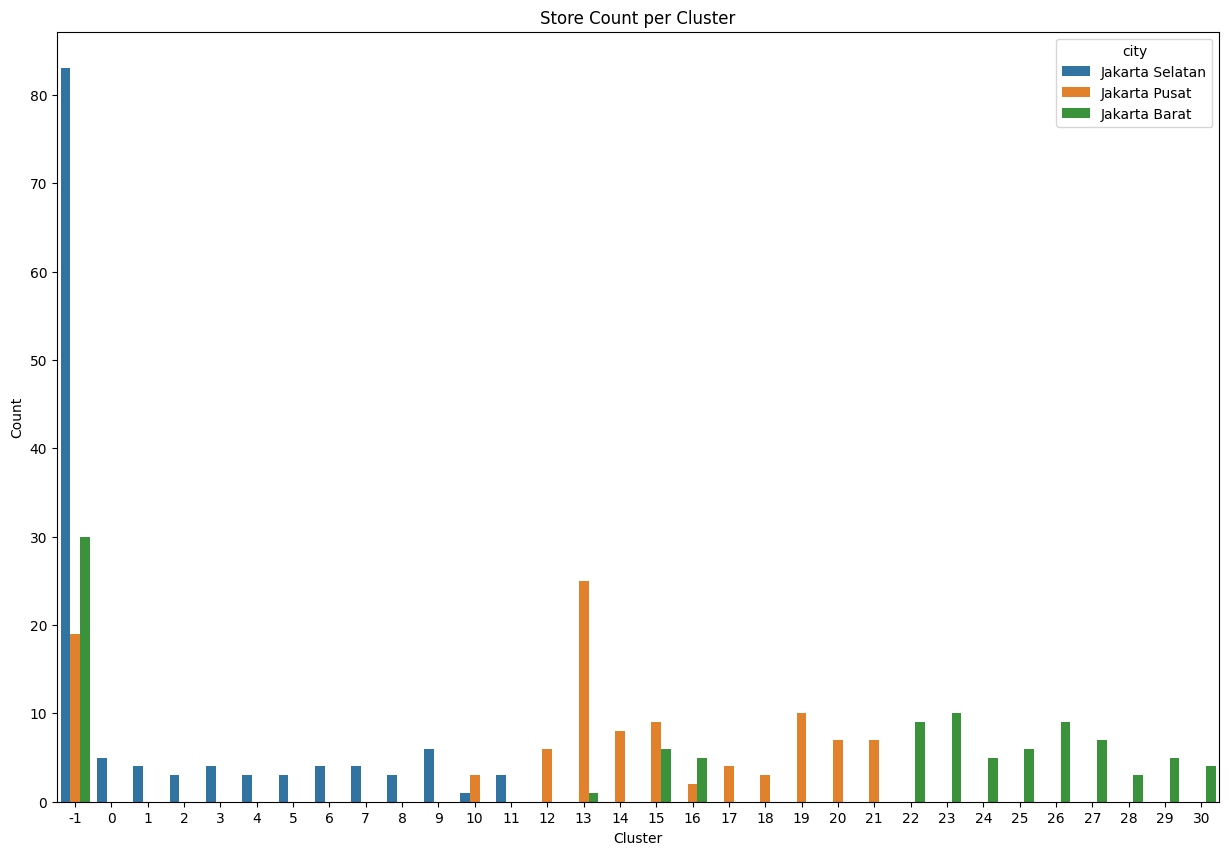

In [21]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='cluster', hue = 'city')
plt.title("Store Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [22]:
tagsDf = df['tags'].apply(pd.Series)
completeDf = pd.concat([df.drop('tags', axis=1), tagsDf], axis=1)

The information below shows the condition of the dataframe after the "tags" column has been split into new individual columns. It can be seen that there are a large number of missing values in each of these new columns, which makes it difficult to conduct a more detailed analysis on these features.

In [23]:
completeDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 0 to 331
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       329 non-null    object 
 1   lat                        329 non-null    float64
 2   lon                        329 non-null    float64
 3   type                       329 non-null    object 
 4   city                       329 non-null    object 
 5   cluster                    329 non-null    int64  
 6   name                       329 non-null    object 
 7   shop                       321 non-null    object 
 8   addr:housename             1 non-null      object 
 9   addr:street                52 non-null     object 
 10  branch                     26 non-null     object 
 11  brand                      290 non-null    object 
 12  brand:wikidata             286 non-null    object 
 13  brand:wikipedia            84 non-null     object 
 14 

# CONCLUSION

In conclusion, the three selected cities Central Jakarta, West Jakarta, and South Jakarta were chosen because, according to Indonesia's 2023 population density data, they have the highest population density. An interactive map using Folium was implemented to provide ease and convenience for end-users or clients in visualizing the tabular data obtained through scraping or querying via the Overpass API from a crowdsourced database called "OpenStreetMap." This source is a highly valuable crowdsourced database but has limitations in data completeness. For instance, additional attributes that could provide further insights, such as those in the "tags" variable, could not be utilized due to the large number of missing values or inconsistencies in available data. Nevertheless, the spatial analysis conducted has offered informative insights into store density and potential areas for expansion.

In the conducted data analysis, the average distance between Indomaret stores as well as their distribution can be observed and studied. Based on these insights, several business strategies can be formulated particularly regarding store density analysis. From the analysis, it is recommended to avoid opening new branches in areas already saturated with Indomaret stores. Instead, areas that are not clustered may be considered, as they have the potential to be suitable locations for new store openings.

South Jakarta stands out as a promising area for expansion. Based on the analysis of the average distance between nearby stores, South Jakarta has the longest average distance compared to the other cities, and the distribution of Indomaret stores in this area is also more spread out. This strategy can help prevent cannibalization between stores.

Another strategy that can be derived from the analysis is for Indomaret to conduct regular surveys of stores located in high-density areas where the distance between stores is relatively close. The goal is to assess whether the sales performance of these stores is balanced and not negatively affecting one another (cannibalization). This issue is particularly relevant in the area between West Jakarta and Central Jakarta, where Indomaret store density is quite high. Therefore, this region may require closer monitoring and further evaluation.

Future development of this analysis can be carried out by collecting more data to improve the quality of insights, such as population figures for each area, building types, store opening hours, and others.